# Subspace Digital Twin, Parameter Selection Under Uncertainty

*BlockScience, April 2024*

Here we execute the PSUU framework for the subspace economic model. 

For more information see the methodology document by Danilo: https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view

## Part 1. Architecture Overview

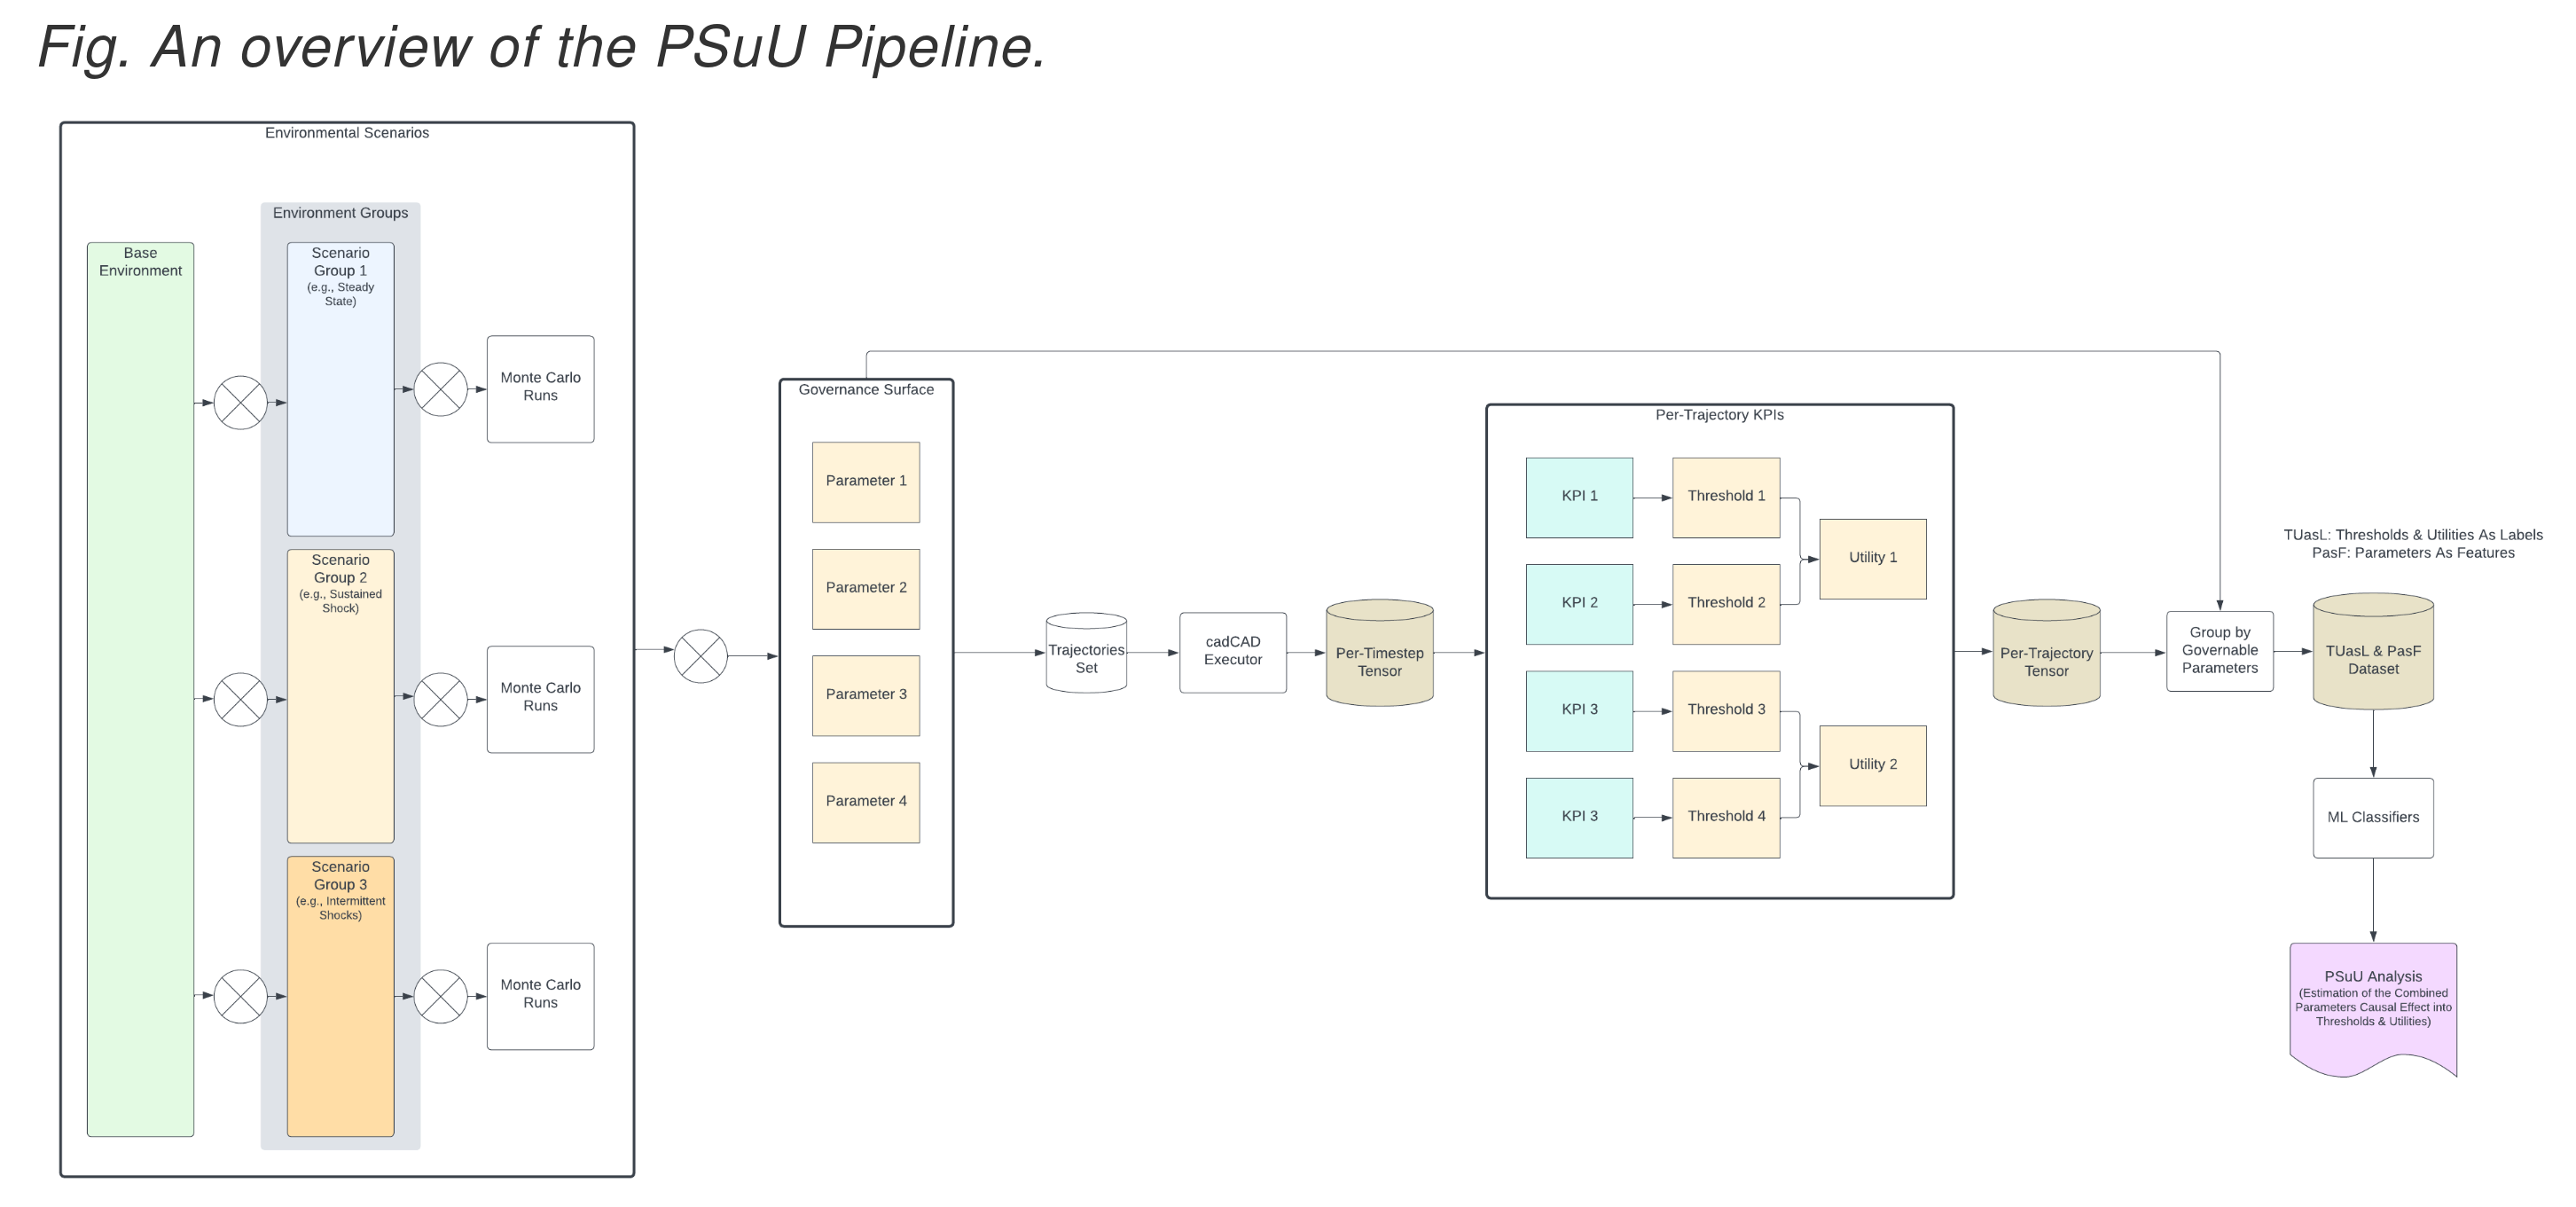

## Part 2. Loading and Cleaning the Per-Timestep Tensor

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import sys
sys.path.append('../')

from glob import glob

latest = sorted(glob("../data/simulations/psuu-2024*"))[-1]

sim_df = pd.read_pickle(latest, compression='gzip')

IndexError: list index out of range

Check number of years per simulation.

In [ ]:
sim_df['days_passed'].max() / 365

Check percentage of total supply issued on average.

In [ ]:
from subspace_model.const import MAX_CREDIT_ISSUANCE

sim_df['allocated_tokens'].mean() / MAX_CREDIT_ISSUANCE

In [ ]:
sim_df

Explode the reference subsidy parameter values.

In [ ]:
import re

# Function to parse a single row of subsidy components
def parse_subsidy_components(row):
    # Pattern to match each SubsidyComponent in the string
    pattern = r'SubsidyComponent\(initial_period_start=(.*?), initial_period_end=(.*?), max_cumulative_subsidy=(.*?), max_reference_subsidy=(.*?)\)'
    
    # Find all matches of the pattern
    matches = re.findall(pattern, row)
    
    # Initialize a dictionary to hold the parsed values
    parsed_values = {}
    
    # Loop through each match and extract values
    for i, match in enumerate(matches, start=1):
        keys = ['initial_period_start', 'initial_period_end', 'max_cumulative_subsidy', 'max_reference_subsidy']
        for j, key in enumerate(keys):
            parsed_values[f'component_{i}_{key}'] = match[j]
    
    return pd.Series(parsed_values)

# Apply the parsing function to each row and join the results with the original DataFrame
expanded_df = pd.concat([sim_df, sim_df['reference_subsidy_components'].apply(parse_subsidy_components)], axis=1)

In [ ]:
sim_df = expanded_df
sim_df

## Part 3. Adding adhoc per-timestep metrics

#### T1: Average over Daily-Average Community Owned Supply Fraction

The Community Owned Supply (COS) is a sum of the following:
1. Vested Community owned supply
2. Community owned supply at launch
3. Issued to Farmers

1. Vested Community Owned Supply

From The Tokenomics Decision Making Forum from Subspace:

In [ ]:
vested_community_ownded_supply_allocation = 1/33.03
vested_community_ownded_supply_allocation

Note: `vested_tokens` and `allocated_tokens` are synonymous.

In [ ]:
sim_df['vested_community_owned_supply'] = sim_df['allocated_tokens'] * vested_community_ownded_supply_allocation
sim_df['vested_community_owned_supply'].mean()

2. Community Owned Supply at Launch

In [ ]:
from subspace_model.const import MAX_CREDIT_ISSUANCE

community_owned_supply_at_launch = 0.2225 * MAX_CREDIT_ISSUANCE
community_owned_supply_at_launch

3. Issued to Farmers

In [3]:
from subspace_model.const import ISSUANCE_FOR_FARMERS

sim_df['issued_to_farmers'] = ISSUANCE_FOR_FARMERS-sim_df['reward_issuance_balance']
sim_df['issued_to_farmers'].mean()


2024-04-04 17:39:45 - subspace-digital-twin - INFO
------------subspace-digital-twin------------


NameError: name 'sim_df' is not defined

Community Owned Supply Fraction

In [2]:
import numpy as np

sim_df['community_owned_supply'] = sim_df['vested_community_owned_supply'] + community_owned_supply_at_launch + sim_df['issued_to_farmers']
sim_df['community_owned_supply_fraction'] = (sim_df['community_owned_supply'] / sim_df['total_supply']).replace(np.inf, np.nan)
sim_df['community_owned_supply_fraction'].mean()

NameError: name 'sim_df' is not defined

In [ ]:
sim_df.query("subset == 1 & run == 1")['community_owned_supply_fraction']

In [ ]:
import hvplot.pandas

sim_df.hvplot.step(x='days_passed', y='community_owned_supply_fraction', by=['subset'], groupby=['run'], title="Community Owned Supply Fraction by Subset")

#### T2: Average over Daily-Average Farmer Subsidy Factor

Farmer Subsidy Factor

In [ ]:
sim_df['storage_fees_to_farmers']

In [ ]:
sim_df

In [ ]:
sim_df.hvplot(x='days_passed', y=['reference_subsidy', 'storage_fees_to_farmers'], groupby=['subset', 'run'])

In [ ]:
sim_df['farmer_subsidy_factor'] = sim_df['reference_subsidy'] / (sim_df['reference_subsidy']+sim_df['storage_fees_to_farmers'])

In [ ]:
sim_df.hvplot.step(x='days_passed', y='farmer_subsidy_factor', by=['subset'], groupby=['run'], title="Farmer Subsidy Factor by Subset")

#### T3: Average over Daily-Sum of Proposing Rewards per Newly Pledged Space

Proposer rewards cost factor

In [ ]:
# proposer_reward = sim_df['reward_proposer_share'] * sim_df['block_reward'] + (1 - sim_df['reward_proposer_share']) * sim_df['block_reward'] / 10

## Part 3. Per-Trajectory KPIs

Threshold Rules

    BMaT: Below the Median across Trajectories
    LMaT: Larger than the Median across Trajectories

https://hackmd.io/iFeP7NemRH--KtWbPP_W0w?view#Per-Trajectory-Metrics

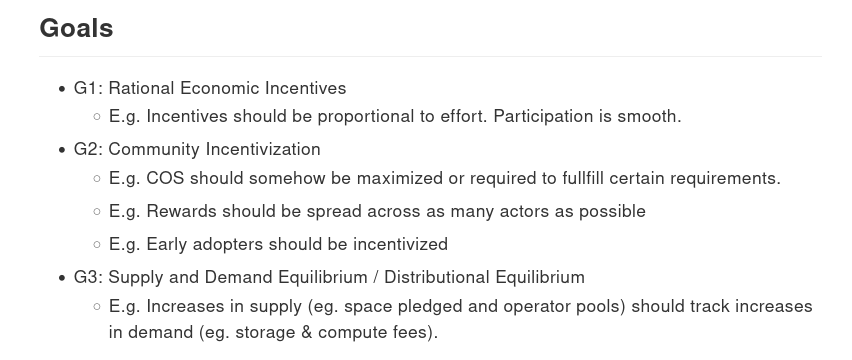

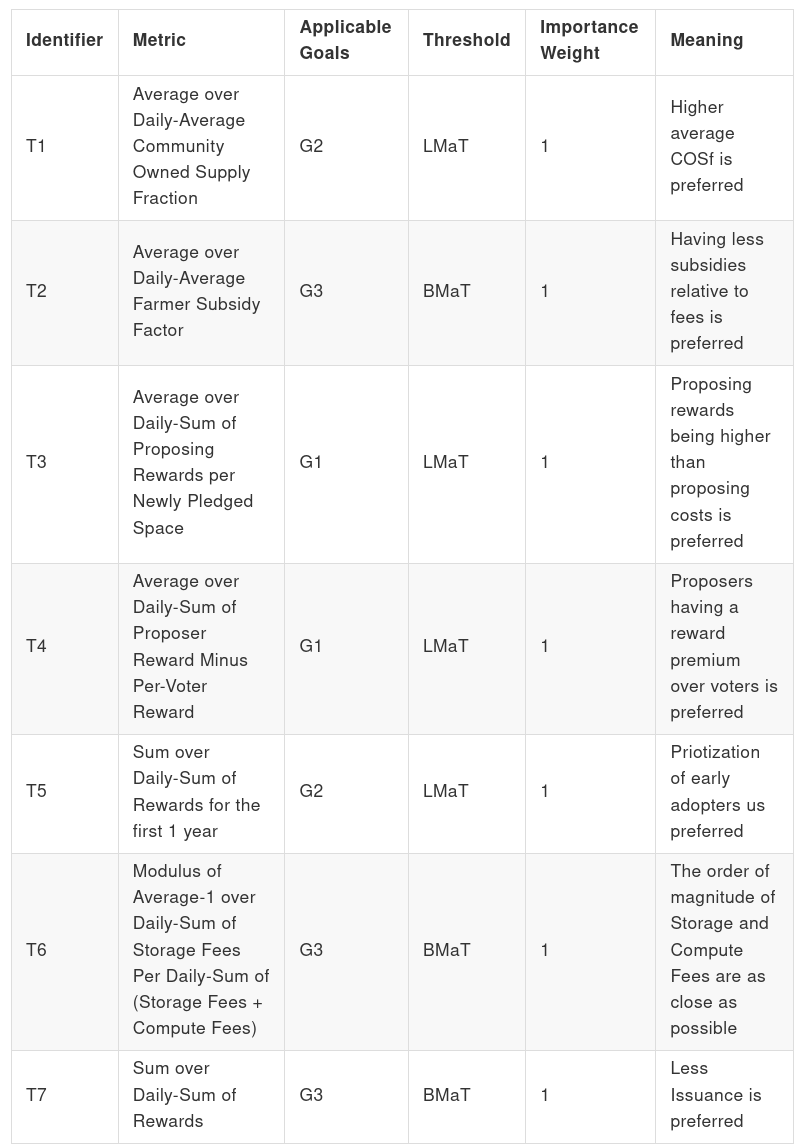

Create a set of governance surface parameters.

In [ ]:
from subspace_model.params import GOVERNANCE_SURFACE

governance_surface_params = (set(GOVERNANCE_SURFACE.keys()) | {c for c in sim_df.columns if 'component' in c}) - {'reference_subsidy_components'}
governance_surface_params

Create the aggregation column list.

In [ ]:
trajectory_id_columns = ['simulation', 'subset', 'run']
agg_columns = trajectory_id_columns + list(governance_surface_params)
agg_columns

In [ ]:
def trajectory_average_community_owned_supply_fraction(trajectory_df) -> float:
    return trajectory_df.community_owned_supply_fraction.mean()

def trajectory_average_farmer_subsidy_factor(trajectory_df) -> float:
    return trajectory_df.farmer_subsidy_factor.mean()

KPIs_per_trajectory = {
    'average_community_owned_supply_fraction': trajectory_average_community_owned_supply_fraction,
    'average_farmer_subsidy_factor': trajectory_average_farmer_subsidy_factor,
}

In [ ]:
kpi_dfs = []
for kpi, kpi_f in KPIs_per_trajectory.items():
    kpi_s = sim_df.groupby(agg_columns).apply(kpi_f)
    kpi_s.name = kpi
    kpi_dfs.append(kpi_s)


all_kpi_df = pd.concat(kpi_dfs, axis=1)

In [ ]:
all_kpi_df

In [ ]:
all_kpi_df.hist()

In [ ]:
import seaborn as sns 
sns.pairplot(all_kpi_df.reset_index().drop(columns=trajectory_id_columns).drop(columns=list(governance_surface_params)))

In [ ]:
threshold_df = all_kpi_df.copy(deep=True)


def transform_column_to_boolean_int(df, column_name, threshold_func):
    return threshold_func(df[column_name]).astype(int)

def threshold_greater_than_median(series):
    return series > series.median()

def threshold_less_than_median(series):
    return series < series.median()

threshold_per_KPI = {
    'average_community_owned_supply_fraction': threshold_greater_than_median,
    'average_farmer_subsidy_factor': threshold_less_than_median,
}

for kpi, func in threshold_per_KPI.items():
    threshold_df[kpi] = transform_column_to_boolean_int(all_kpi_df, kpi, func)


threshold_df

In [ ]:
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"

In [ ]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


df = threshold_df.reset_index()
kpi = 'average_community_owned_supply_fraction'
features = list(set(governance_surface_params) - {kpi})
X = df.loc[:, features]
y = df.loc[:, kpi]

model = DecisionTreeClassifier(max_depth=3)
rf = RandomForestClassifier()
model.fit(X, y)
rf.fit(X, y)



rf_df = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                    columns=['features', 'importance'])
        .sort_values(by='importance', ascending=False)
        )


fig, axes = plt.subplots(nrows=2,
                            figsize=(36, 12),
                            dpi=100,
                            gridspec_kw={'height_ratios': [3, 1]})

(ax_dt, ax_rf) = axes[0], axes[1]
plot_tree(model,
            rounded=True,
            proportion=True,
            fontsize=8,
            feature_names=X.columns,
            class_names=['threshold not met', 'threshold met'],
            filled=True,
            ax=ax_dt)
ax_dt.set_title(
    f'Decision tree, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
sns.barplot(data=rf_df,
            x=rf_df.features,
            y=rf_df.importance,
            ax=ax_rf,
            label='small')
plt.setp(ax_rf.xaxis.get_majorticklabels(), rotation=45)
ax_rf.set_title(f'Feature importance')
plt.show()